This project is going to take the multichannel delay, apply the hadamard and check that the result is the same as Cipriani's FDN before attempting to optimize.

Credit to https://github.com/radoslawregula/reverb-algorithms/blob/master/fdn_prototype.pym for the damping filter and help with design.

In [1]:
import librosa
import scipy
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as display
import math
import soundfile as sf
import numpy.typing as npt
from numba import jit, prange
from numba import vectorize, int32, int64, float32, float64
import timeit
from tqdm.auto import tqdm
from numba_progress import ProgressBar
import pandas as pd

In [2]:
%config InlineBackend.figure_formats = ['svg']
plt.style.use('dark_background')

In [3]:
SAMPLE_RATE = 44100

In [4]:
@jit("float64[:](float64[:], int32, boolean)", nopython=True, fastmath=False)
def feedforward_delay(x, loop_time=1, milliseconds=False):
    
    M = (loop_time / 1000) * SAMPLE_RATE if milliseconds else loop_time
    M = int(M) if (M > 0) else 1
    
    d = np.zeros(M) # wrap this buffer and add last value to input array.
    p = 0 # delay buffer index
    y = np.zeros(x.size) # output buffer
    
    for i in range(x.size):
        
        # p = p % M
        
        y[i] = d[p % M] 
        d[p % M] = x[i] # will not here the result until p reaches the beginning of the delay buffer d.
        # p = p + 1 if (p < M-1) else 0
        p += 1
        
    return y

In [5]:
@jit("float64[:](float64[:], float64, float64)", nopython=True, fastmath=False)
def onepole(input, freq=200, sample_rate=SAMPLE_RATE):
    
    output = np.zeros((input.shape[-1]))
    
    x = np.exp(-2.0*np.pi*freq/sample_rate)
    
    a0 = 1-x
    b1 = -x
    
    tmp = 0
    
    for i in range(len(output)):
        output[i] = a0 * input[i] - b1*tmp
        tmp = output[i]
        
    return output

In [6]:
@jit("float64[:](float64[:], float64)", nopython=True, fastmath=False)
def dc_block(input, sample_rate=SAMPLE_RATE):
    
    freq = 20
    output = np.zeros((input.shape[-1]))
    
    x = np.exp(-2.0*np.pi*freq/sample_rate)
    
    a0 = 1-x
    b1 = -x
    
    tmp = 0
    
    for i in range(len(output)):
        output[i] = a0 * input[i] - b1*tmp
        tmp = output[i]
        
    return input - output

In [7]:
def prime(x, y):
    prime_list = []
    for i in range(x, y):
        if i == 0 or i == 1:
            continue
        else:
            for j in range(2, int(i/2)+1):
                if i % j == 0:
                    break
            else:
                prime_list.append(i)
    return np.array(prime_list)

In [8]:
@jit("int32[:](int32, float64, float64, float64, int32[:])", nopython=True, fastmath=False)
def del_list(n=16, min_dist=1., max_dist=100., curve=1, prime_list=np.array([0])):
    
    """
    create a list of delay times, with a minimum and maximum distance.
    
    n: number of delay times
    curve: exponential value to multiply each delay time by
    """
    
    # divided by speed of sound multiplied by milliseconds.
    min_dist  /= 344
    min_dist *= 1000.
    
    max_dist  /= 344.
    max_dist *= 1000.
    
    l = np.power(np.linspace(0, 1, n), curve)
    l = (((min_dist + (l * (max_dist - min_dist))) / 1000) * SAMPLE_RATE) + 0.5
    
    current = prime_list[(np.abs(prime_list - l[0])).argmin()]
    
    for i in range(n):
        
        index = (np.abs(prime_list - l[i])).argmin()
        
        l[i] = prime_list[index]
        
        while (current >= l[i]):
            index += 1
            l[i] = prime_list[index]
        
        current = l[i]
    
    return l.astype(np.int32)

In [9]:
@jit("float64[:](int32, float64, float64, float64)", nopython=True, fastmath=False)
def filter_list(n=16, min_freq=200, max_freq=1200, frequency_curve=3.5):
    l = np.power(np.linspace(0, 1, n), frequency_curve)
    l = min_freq + (l * (max_freq - min_freq))
    return l

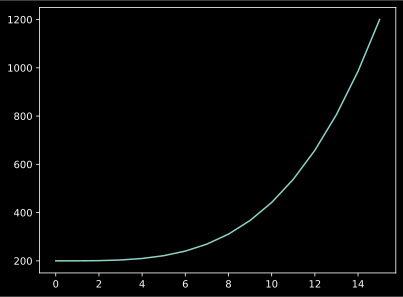

In [10]:
# ok now I need to apply that list to a list of frequencies in the reverb!
plt.plot(filter_list(n=16, min_freq=200, max_freq=1200, frequency_curve=3.5))

In [11]:
def plot(x, title=None):
    x_axis = np.arange(0, x.shape[-1])
    fig = plt.figure()
    fig.suptitle(title)
    gs = fig.add_gridspec(x.shape[0], hspace=0.1)
    axs = gs.subplots(sharex=True, sharey=True)
    for i, ax in enumerate(axs):
        ax.plot(x_axis, x[i])
        ax.label_outer()

In [12]:
prime_list = prime(0, 30000)
prime_list.dtype

dtype('int32')

In [13]:
@vectorize([float64(float64)])
def t60(duration_in_samples):
    return np.exp(np.log(0.001) / duration_in_samples)

In [14]:
@vectorize([float64(float64)])
def t60_time(multiplier):
    return np.log(0.001) / np.log(multiplier)

In [163]:
@jit("float64[:](float64[:], float64, float64, float64, float64, float64, float64, float64, float64[:, :], int32[:])", nopython=True, fastmath=True, parallel=False)
def simple_fdn(input, decay=None, min_dist=1., max_dist=100., distance_curve=3., min_freq=11000, max_freq=18000, frequency_curve=1.809, H=np.array(0), prime_list=np.array(0)):
    
    # assert all values have been entered.
    assert decay != None, f"decay between 0 and 1 expected, got: {decay}"
    assert np.abs(decay) <= 1.0, f"decay between 0 and 1 expected, got: {decay}"

    # scale delay time parameter values if they are within range.
    min_dist = min_dist * 100. if (min_dist > 0) else 1.
    max_dist = max_dist * 100. if (max_dist > 0) else 1.
    
    # swap if minimum is larger than maximum
    if (min_dist > max_dist):
        min_dist, max_dist = max_dist, min_dist
    
    distance_curve = distance_curve * 3. if (distance_curve > 0.) else 1
    
    min_freq = min_freq * 20000 if (min_freq > 0) else 20000
    max_freq = max_freq * 20000 if (max_freq > 0) else 20000
    
    if (min_freq > max_freq):
        min_freq, max_freq = max_freq, min_freq
    
    frequency_curve = frequency_curve * 3. if (frequency_curve > 0.) else 1
    
    l = del_list(n=16, min_dist=min_dist, max_dist=max_dist, curve=distance_curve, prime_list=prime_list)
    
    N = l.shape[0]
    
    freqs = filter_list(n=N, min_freq=min_freq, max_freq=max_freq, frequency_curve=frequency_curve)
    
    # default smallest decay time equivalent to largest delay length in milliseconds
    decay = decay * 2000. if (decay > 0.) else max_dist
    
    # empty array to calculate each t60 value.
    decay_ms = np.zeros(N)
    
    # print gain calculation for each delay line as a function of t60
    # convert ms to samples and then divide by loop_time in samples then take t60.
    for i in range(N):
        decay_ms[i] = t60(((decay/1000) * SAMPLE_RATE) / l[i])
        
        
    # all generated impulse responses should be 2 seconds.
    # if processing a real world signal the sample may be larger than two seconds.
    # check for that case and leave if less than 88200 add until it is
    
    extra_time_in_samples = int(t60_time(decay_ms[-1]) * l[-1])
    difference = (SAMPLE_RATE * 2) - extra_time_in_samples
    if (difference) > 0: extra_time_in_samples += difference 
    
    x = np.zeros((N, input.shape[-1] + extra_time_in_samples))
    x[:, :input.shape[-1]] = input

    y = np.zeros(x.shape)
    f_y = np.zeros(x.shape)
    output = np.zeros(x.shape)
    feedback = np.zeros(x.shape)
    feedback[:, :] = x[:, :]
    
    num_iterations = int(np.ceil((44100 / l[0])  * (decay / 1000)))
    
    for j in prange(num_iterations):
        for i in prange(N):
            y[i] = feedforward_delay(feedback[i] * decay_ms[i], l[i], milliseconds=False)
            f_y[i] = onepole(y[i], freq=freqs[i], sample_rate=SAMPLE_RATE)
            output[i] += dc_block(f_y[i], sample_rate=SAMPLE_RATE)
        feedback = H @ f_y
        
    y = np.sum(output, axis=0)
    
    return y * (1 / np.max(np.abs(y)))

In [164]:
# unipolar impulse so as not to offset resulting impulse response
x = np.zeros(2)
x[0] = -1
x[1] = 1

In [165]:
# make sure all the impulse responses are 88200 samples long.

y = simple_fdn(x,
                   decay=1,
                   min_dist=0.,
                   max_dist=1.,
                   distance_curve=2.,
                   min_freq=0.,
                   max_freq=1.,
                   frequency_curve=2,
                   H=H,
                   prime_list=prime_list)

0.9645040914754979 -1.0


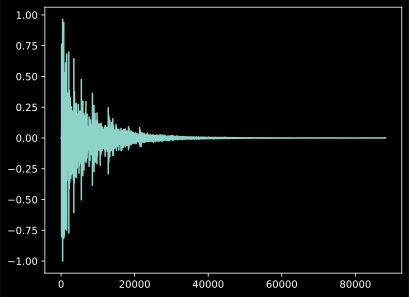

In [166]:
plt.plot(y)
print(np.max(y), np.min(y))

In [167]:
# 1. create a random list of parameter values and store in a data frame

impulse_num = 10

decay           = np.zeros(impulse_num)
min_dist        = np.zeros(impulse_num)
max_dist        = np.zeros(impulse_num)
distance_curve  = np.zeros(impulse_num)
min_freq        = np.zeros(impulse_num)
max_freq        = np.zeros(impulse_num)
frequency_curve = np.zeros(impulse_num)

for i in range(impulse_num):
    decay[i]           = np.random.random()
    min_dist[i]        = np.random.random()
    max_dist[i]        = np.random.random()
    distance_curve[i]  = np.random.random()
    min_freq[i]        = np.random.random()
    max_freq[i]        = np.random.random()
    frequency_curve[i] = np.random.random()
    

In [160]:
df = pd.DataFrame(
    {
        "Decay":           decay,
        "Min distance":    min_dist,
        "Max distance":    max_dist,
        "Distance curve":  distance_curve,
        "Low frequency":   min_freq,
        "High frequency":  max_freq,
        "Frequency curve": frequency_curve
    }
)

df

,Decay,Min distance,Max distance,Distance curve,Low frequency,High frequency,Frequency curve
0,0.479857,0.140281,0.530885,0.613729,0.032160,0.170914,0.825678
1,0.824155,0.844989,0.126832,0.315341,0.647766,0.803501,0.398882
2,0.774668,0.602636,0.798623,0.521593,0.404067,0.626507,0.155036
3,0.639434,0.943511,0.198273,0.471056,0.966985,0.157961,0.508505
4,0.807672,0.236888,0.801757,0.781698,0.496136,0.942044,0.559815
5,0.909358,0.739065,0.622112,0.383881,0.218036,0.792291,0.536862
6,0.309160,0.730302,0.600295,0.973334,0.823644,0.871308,0.849288
7,0.871659,0.942887,0.039093,0.581650,0.637802,0.112973,0.068795
8,0.131389,0.541141,0.665453,0.724964,0.504093,0.551127,0.112507
9,0.876996,0.456244,0.870032,0.835973,0.293290,0.118809,0.456972


(16, 88202)
(16, 88202)
(16, 88202)
(16, 88202)
(16, 88202)
(16, 88202)
(16, 88202)
(16, 88202)
(16, 88202)
(16, 88202)


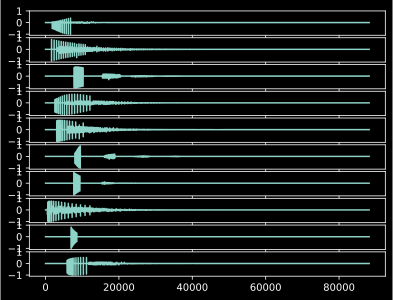

In [162]:
# use your plot function to plot all 10 impulses.
# make a grid version.

H = scipy.linalg.hadamard(16) * 0.25
IMPULSE_LENGTH = (SAMPLE_RATE * 2) + x.shape[-1]

# store impulse responses in a 2d array.
impulse_responses = np.ndarray((impulse_num, IMPULSE_LENGTH))

for i in range(impulse_num):
    y = simple_fdn(x,
                   decay=decay[i],
                   min_dist=min_dist[i],
                   max_dist=max_dist[i],
                   distance_curve=distance_curve[i],
                   min_freq=min_freq[i],
                   max_freq=max_freq[i],
                   frequency_curve=frequency_curve[i],
                   H=H,
                   prime_list=prime_list)
    impulse_responses[i, :] = y

plot(impulse_responses)

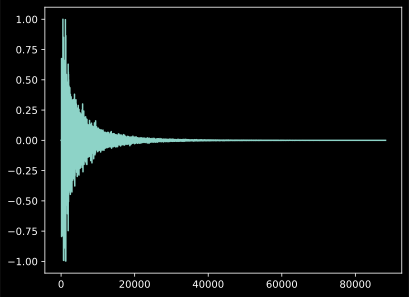

In [83]:
plt.plot(y[:100000])
Audio(y, rate=44100)

# fdn example with piano.

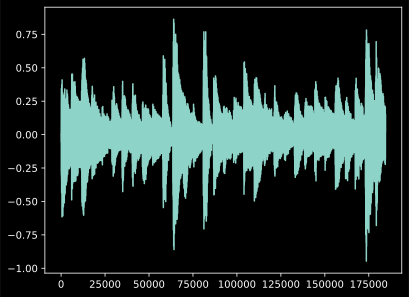

In [153]:
audio, sr = librosa.load("vs_piano_loop.wav")
plt.plot(audio)
Audio(audio, rate=sr)

In [155]:
# cast audio to np.float64, FIND A 44100Hz sample!
y = simple_fdn(audio.astype(np.float64),
               decay=1,
               min_dist=0.,
               max_dist=1.,
               distance_curve=2.,
               min_freq=0.8,
               max_freq=0.9,
               frequency_curve=2,
               H=H,
               prime_list=prime_list)

(16, 272730)


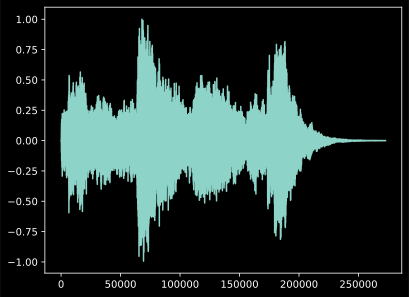

In [156]:
plt.plot(y)
Audio(y, rate=sr)